**Data Overview:**
https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data

**Data Columns:**
Attributes: Tweet ID, Subject, Tweet 


In [122]:
# general library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy 
import warnings
import re
import string
import random
from collections import defaultdict
from collections import Counter

# text processing
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer , TweetTokenizer
from nltk.stem import WordNetLemmatizer ,PorterStemmer
from nltk.corpus import stopwords

# training & prediction
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import tensorflow as tf

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


nlp = spacy.load("en_core_web_sm")
warnings.filterwarnings('ignore')

In [123]:
df = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv', header=0, names=["Tweet_ID", "Subject", "Sentiment", "Tweet"])
df.info()
df.sample(15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   74681 non-null  int64 
 1   Subject    74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


,Tweet_ID,Subject,Sentiment,Tweet
48126,5862,HomeDepot,Negative,"Dear @ HomeDepot and @ HDCares, thank you for ..."
56377,11275,TomClancysRainbowSix,Neutral,Watch my video!
39771,1228,Battlefield,Irrelevant,com A ban for Battlefield Part 4 player by JoC...
19031,12461,WorldOfCraft,Neutral,We have discovered a new secret in Maldraxxus!...
25600,4794,Google,Negative,a.Pichai plz your answer. Or you want governme...
47589,5765,HomeDepot,Positive,Because I love the smell of Home Sweet Depot [...
71789,11098,TomClancysGhostRecon,Positive,Guy named Beatboxx on Reddit posted this. If t...
23850,4489,Google,Negative,Netflix is the new Google. Products kill the w...
23636,4451,Google,Neutral,Hello! I’ve signed on for the de-prompt and ha...
67737,3601,Cyberpunk2077,Neutral,Oh my my Lanta.


In [124]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71655 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   71655 non-null  int64 
 1   Subject    71655 non-null  object
 2   Sentiment  71655 non-null  object
 3   Tweet      71655 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.7+ MB


In [125]:
print(f'The number of unique subjects : {len(df.Subject.unique())}')
df.Subject.unique()

The number of unique subjects : 32


array(['Borderlands', 'CallOfDutyBlackopsColdWar', 'Amazon', 'Overwatch',
       'Xbox(Xseries)', 'NBA2K', 'Dota2', 'PlayStation5(PS5)',
       'WorldOfCraft', 'CS-GO', 'Google', 'AssassinsCreed', 'ApexLegends',
       'LeagueOfLegends', 'Fortnite', 'Microsoft', 'Hearthstone',
       'Battlefield', 'PlayerUnknownsBattlegrounds(PUBG)', 'Verizon',
       'HomeDepot', 'FIFA', 'RedDeadRedemption(RDR)', 'CallOfDuty',
       'TomClancysRainbowSix', 'Facebook', 'GrandTheftAuto(GTA)',
       'MaddenNFL', 'johnson&johnson', 'Cyberpunk2077',
       'TomClancysGhostRecon', 'Nvidia'], dtype=object)

In [126]:
subjects =df.Subject.value_counts()
subjects.to_frame()

,count
Subject,
TomClancysRainbowSix,2328
Verizon,2319
MaddenNFL,2315
CallOfDuty,2314
Microsoft,2304
WorldOfCraft,2300
NBA2K,2299
LeagueOfLegends,2296
TomClancysGhostRecon,2291


In [127]:
print(f'The unique values of Mode : {len(df.Sentiment.unique())}')
print(df.Sentiment.unique())
sentiment =df.Sentiment.value_counts()
sentiment.to_frame()

The unique values of Mode : 4
['Positive' 'Neutral' 'Negative' 'Irrelevant']


,count
Sentiment,
Negative,21698
Positive,19712
Neutral,17708
Irrelevant,12537


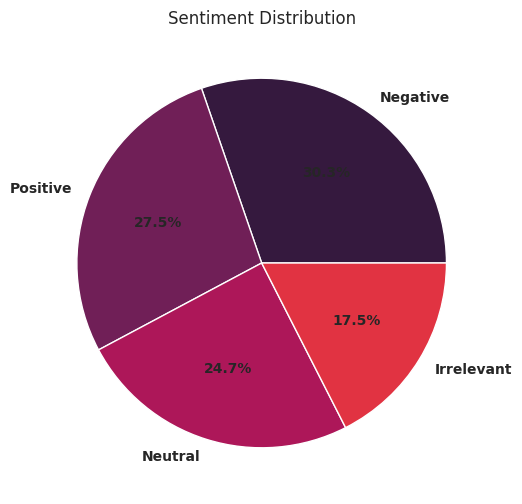

In [128]:
plt.figure(figsize=(6,6))
plt.pie(x = sentiment.values , labels=sentiment.keys() ,autopct="%1.1f%%" , 
textprops={"fontsize":10,"fontweight":"black"},colors=sns.color_palette("rocket"))
plt.title('Sentiment Distribution') 
plt.show()

In [129]:
# TODO: perform contraction expansion using Contractions from pycontractions

def clean_emoji(tx):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols 
                           u"\U0001F680-\U0001F6FF"  # transport 
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', tx)

def text_cleaner(text):
    text = re.sub(r"won\'t", "would not", text)
    text = re.sub(r"im", "i am", text)
    text = re.sub(r"Im", "I am", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don\'t", "do not", text)
    text = re.sub(r"shouldn\'t", "should not", text)
    text = re.sub(r"needn\'t", "need not", text)
    text = re.sub(r"hasn\'t", "has not", text)
    text = re.sub(r"haven\'t", "have not", text)
    text = re.sub(r"weren\'t", "were not", text)
    text = re.sub(r"mightn\'t", "might not", text)
    text = re.sub(r"didn\'t", "did not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\!\?\.\@]',' ' , text)
    text = re.sub(r'[!]+' , '!' , text)
    text = re.sub(r'[?]+' , '?' , text)
    text = re.sub(r'[.]+' , '.' , text)
    text = re.sub(r'[@]+' , '@' , text)
    text = re.sub(r'unk' , ' ' , text)
    text = re.sub('\n', '', text)
    text = text.lower()
    text = re.sub(r'[ ]+' , ' ' , text)
    
    return text


In [153]:
# df['Tweet'] = df['Tweet'].apply(lambda x : clean_emoji(x))
df['Tweet'] = df['Tweet'].apply(lambda x : text_cleaner(x))
df['Tweet']= df['Tweet'].apply(lambda x : Tokenizer.tokenize(x))
df['Tweet'].to_frame()


,Tweet
0,"[come, border, kill]"
1,"[get, borderland, kill]"
2,"[come, borderland, murder]"
3,"[get, borderland, 2, murder]"
4,"[get, borderland, murder]"
...,...
74676,"[realiz, window, partit, mac, like, 6, year, b..."
74677,"[realiz, mac, window, partit, 6, year, behind,..."
74678,"[realiz, window, partit, mac, 6, year, behind,..."
74679,"[realiz, window, partit, mac, like, 6, year, b..."


In [150]:
stopwords_list = stopwords.words('english')

#TODO: Lemmatizer vs Stemmer --> analyze situations in which either is preferred.
# lemmatizer = WordNetLemmatizer() 
Stemmer = PorterStemmer()
def stopwords_cleaner(text):
#   word = [lemmatizer.lemmatize(letter) for letter in text if letter not in stopwords_list]
    word = [Stemmer.stem(letter) for letter in text if letter not in stopwords_list]
    stems = ' '.join(word)
    return stems

df['Tweet'] = df['Tweet'].apply(lambda x : stopwords_cleaner(x))
# stopwords_cleaner(Tokenizer.tokenize(df.Tweet[100]))

In [152]:
df['Tweet'][:10].to_frame()

,Tweet
0,come border kill
1,get borderland kill
2,come borderland murder
3,get borderland 2 murder
4,get borderland murder
5,spent hour make someth fun know huge borderlan...
6,spent coupl hour someth fun know huge borderla...
7,spent hour someth fun know huge borderland fan...
8,spent hour make someth fun know huge rhandlerr...
9,2010 spent hour make someth fun know huge rhan...


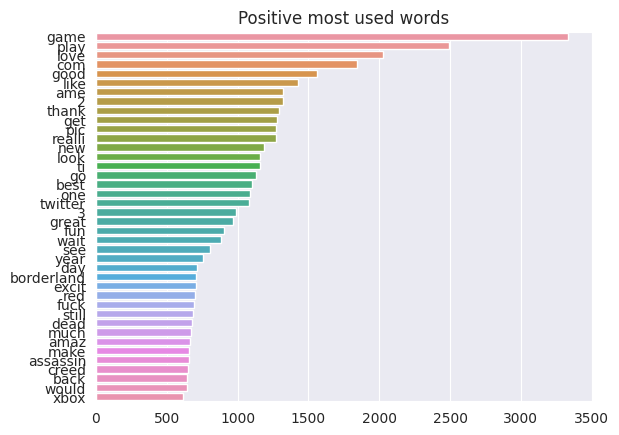

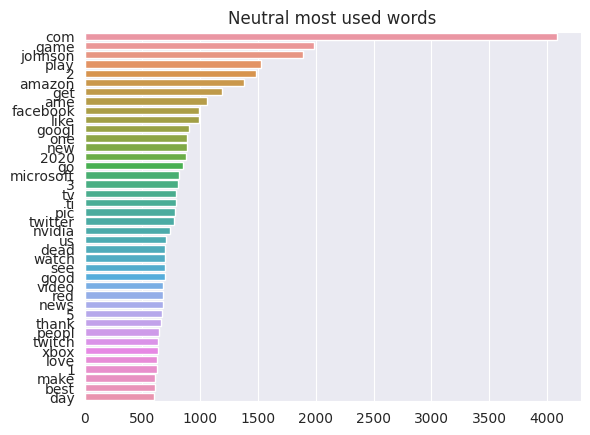

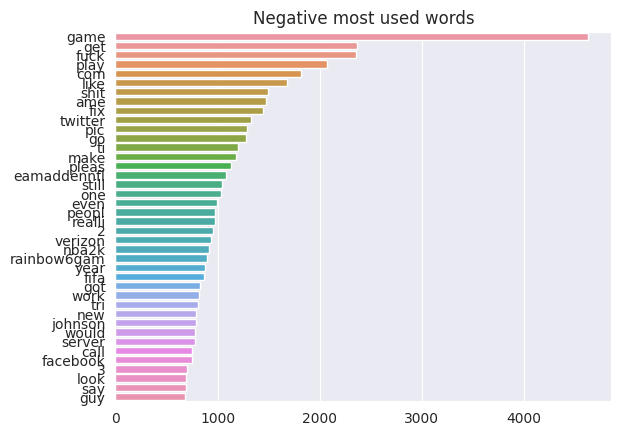

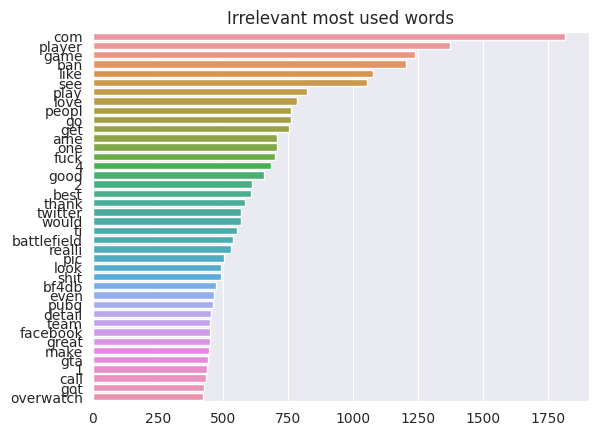

In [133]:
#Determine 10 most commonly associated words for each sentiment 
for inx , value in enumerate(sentiments):
    
    counter = Counter(make_corpus(value))
    most_common = counter.most_common()

    x = []
    y = []

    for word, count in most_common[:40]:
         if word not in stop:
            x.append(word)
            y.append(count)
         
    sns.barplot(x=y, y=x, orient='h')
    plt.title(f'{value} most used words')
    plt.show()

In [134]:
df['Sentiment'] = df['Sentiment'].replace({'Positive' : 1 ,  'Negative' : 0 ,'Neutral':2 , 'Irrelevant' : 2 })

In [135]:
df.sample(10)

,Tweet_ID,Subject,Sentiment,Tweet
65234,7972,MaddenNFL,0,lol say exactli wrong
58803,3280,Facebook,2,facebook phone meme video done hip go along ca...
8289,9422,Overwatch,2,best perfect way protect planet samsung galaxi...
4574,1986,CallOfDutyBlackopsColdWar,1,look great super pump
26476,947,AssassinsCreed,0,love assassin creed ezio colletct would seem w...
44325,11614,Verizon,0,verizon exchang websit still work last person ...
35792,8145,Microsoft,1,jasmin work within panel expert microsoft crea...
21479,4077,CS-GO,0,shit updat ca use ob nvidia shadow play even d...
52266,10579,RedDeadRedemption(RDR),0,feel finish game crash mani ti ame especi play...
25677,807,AssassinsCreed,1,finish assassin intern creed odyssey shadow of...


In [136]:
# Below class used for the model construction
class Dataset:
    def __init__(self,text,sentiment):
        self.text = text
        self.sentiment = sentiment
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = self.text[item,:]
        target = self.sentiment[item]
        return {
            "text": torch.tensor(text,dtype = torch.long),
            "target": torch.tensor(target,dtype = torch.long)
        }

In [137]:
#Using the text_to_sequence method, the words are converted into vectors that then be used for analysis
#words with similar meanings will have a minimal distance --> distance between vectors encodes semantic similarity 

def load_vectors(fname):
    fin = open(fname , encoding="utf8")
    data = {}
    for line in fin:
        tokens = line.split()
        data[tokens[0]] = np.array([float(value) for value in tokens[1:]])
        
    return data

In [138]:
def create_embedding_matrix(word_index,embedding_dict):

    embedding_matrix = np.zeros((len(word_index)+1,300))
    for word, i in word_index.items():
        if word in embedding_dict:
            embedding_matrix[i] = embedding_dict[word]
            
    return embedding_matrix

In [139]:
class sentimentBiLSTM(nn.Module):
#inherited from nn.Module
    
    def __init__(self, embedding_matrix, hidden_dim, output_size):
      
        #initializing the params by initialization method 
        super(sentimentBiLSTM, self).__init__()
        self.embedding_matrix = embedding_matrix
        self.hidden_dim = hidden_dim
        num_words = self.embedding_matrix.shape[0]
        embed_dim = self.embedding_matrix.shape[1]
        # craetinh embedding layer
        self.embedding = nn.Embedding(num_embeddings=num_words,embedding_dim=embed_dim)
        
        ## initializes the weights of the embedding layer to the pretrained embeddings in 
        ## embedding_matrix. It first converts embedding_matrix to a PyTorch tensor and 
        ## wraps it in an nn.Parameter object, which makes it a learnable parameter of the model.
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_dim,hidden_dim,bidirectional=True,batch_first=True)

        #it is multuplied by 2 becuase it is bi_directional if one-sided it didnt need.
        self.fc = nn.Linear(hidden_dim*2, output_size)
        

    #we need a forward function to model calculate the cost and know how bad the params is .  
    # However , it can be written in a line of code but if we want to track it it is easier way.  
    def forward(self, x):

       
        embeds = self.embedding(x)
        lstm_out,_ = self.lstm(embeds)
        lstm_out = lstm_out[:, -1]
        out = self.fc(lstm_out)

        return out

In [140]:
y = df.Sentiment.values
train_df,test_df = train_test_split(df,test_size = 0.2, stratify = y)


In [141]:
MAX_LEN = 167
BATCH_SIZE = 32
hidden_dim = 64
output_size = 3

if torch.cuda.is_available():
    
       device = torch.device("cuda")
   
else:
       device = torch.device("cpu")
    

print(f'Current device is {device}')


tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.Tweet.values.tolist())

#convert words --> vectors 
xtrain = tokenizer.texts_to_sequences(train_df.Tweet.values)
xtest = tokenizer.texts_to_sequences(test_df.Tweet.values)

#TODO: MAX_LEN value is calculated by mean + 2 * s.d.
xtrain = tf.keras.preprocessing.sequence.pad_sequences(xtrain,maxlen = MAX_LEN)
xtest = tf.keras.preprocessing.sequence.pad_sequences(xtest,maxlen = MAX_LEN)

train_dataset = Dataset(text=xtrain,sentiment=train_df.Sentiment.values)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,drop_last=True)
valid_dataset = Dataset(text=xtest,sentiment=test_df.Sentiment.values)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=BATCH_SIZE,drop_last=True)


Current device is cpu


In [142]:
# check a batch of data 
one_batch = next(iter(train_loader))
one_batch

{'text': tensor([[    0,     0,     0,  ...,   114,   107,  6143],
         [    0,     0,     0,  ...,   207,   209,   163],
         [    0,     0,     0,  ...,   160,    84, 18693],
         ...,
         [    0,     0,     0,  ...,    26,    41,  1664],
         [    0,     0,     0,  ...,  1764,    46,  2447],
         [    0,     0,     0,  ...,  1064,     1,   258]]),
 'target': tensor([0, 2, 0, 0, 2, 0, 0, 2, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 2, 2, 2, 2, 0, 1,
         2, 1, 0, 2, 0, 2, 1, 0])}

In [143]:
#uses GloVe from the Stanford NLP group to improve vectorization of words --> more effective word embeddings
embedding_dict = load_vectors('/kaggle/input/glove6b300dtxt/glove.6B.300d.txt')
embedding_matrix = create_embedding_matrix(tokenizer.word_index,embedding_dict)

In [144]:
model = sentimentBiLSTM(embedding_matrix ,  hidden_dim, output_size)
model = model.to(device)
print(model)

sentimentBiLSTM(
  (embedding): Embedding(23571, 300)
  (lstm): LSTM(300, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [145]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

#Try with momentum and other optimizer techniques
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss() 

def acc(pred,label):
    pred = pred.argmax(1)
    return torch.sum(pred == label.squeeze()).item()

In [146]:
clip = 5
epochs = 9
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    # for getting loss and accuracy for train
    train_losses = []
    train_acc = 0.0

    #put model on train mode
    model.train()
    correct = 0

    # initialize hidden state 
    for data in train_loader:  

        #get text and target 
        inputs = data['text']
        labels = data['target']

        #put them on GPU and right dtypes
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

         #gradient becomes zero=> avoid accumulating 
        model.zero_grad()
        output = model(inputs)
          # calculate the loss and perform backprop
        loss = criterion(output, labels.long())
        loss.backward()
        train_losses.append(loss.item())
        # accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in LSTMs
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
    # for getting loss and accuracy for valiadtion
    val_losses = []
    val_acc = 0.0

    #put model on evaluation mode
    model.eval()
    for data in valid_loader:

        #get text and target 
        inputs = data['text']
        labels = data['target']

        #put them on GPU and right dtypes
        inputs = inputs.to(device,dtype=torch.long)
        labels = labels.to(device,dtype=torch.float)

        #gradient becomes zero=> avoid accumulating 
        model.zero_grad()
        output = model(inputs)

        output = model(inputs)
        #Loss calculating 
        val_loss = criterion(output, labels.long())
        #append Loss to the above list
        val_losses.append(val_loss.item())

        # calculating accuracy 
        accuracy = acc(output,labels)
        val_acc += accuracy
        epoch_train_loss = np.mean(train_losses)

        #using schedule lr if you need
#         schedul_learning.step()
#         schedul_learning

    #appending all accuracy and loss to the above lists and variables
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        #each time that model(params) get better you can save the model(you have to enter a path ou you pc and save with pt file)
        # torch.save(model.state_dict(), r'C:\Users\payama\Desktop\Projects kaggle\NLP\vectors features\BidirectionalLSTM.pt')
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        print(f'Validation loss decreased ({valid_loss_min} --> {epoch_val_loss})  Saving model ...')
        # save model if better result happends
        valid_loss_min = epoch_val_loss
    print(30 * '==' , '>')

Epoch 1
train_loss : 0.8619254489706456 val_loss : 0.7747247161081173
train_accuracy : 59.22650198869584 val_accuracy : 65.00593119810202
Validation loss decreased (inf --> 0.7747247161081173)  Saving model ...
============================================================ >
Epoch 2
train_loss : 0.6752125892740332 val_loss : 0.6528432304560472
train_accuracy : 70.48356709231736 val_accuracy : 71.80238643500104
Validation loss decreased (0.7747247161081173 --> 0.6528432304560472)  Saving model ...
============================================================ >
Epoch 3
train_loss : 0.5328740511674045 val_loss : 0.5969271783194019
train_accuracy : 77.86441978926803 val_accuracy : 75.20759193357058
Validation loss decreased (0.6528432304560472 --> 0.5969271783194019)  Saving model ...
============================================================ >
Epoch 4
train_loss : 0.4141573364768928 val_loss : 0.5294105043547266
train_accuracy : 83.23913195171308 val_accuracy : 78.73839927430046
Validation

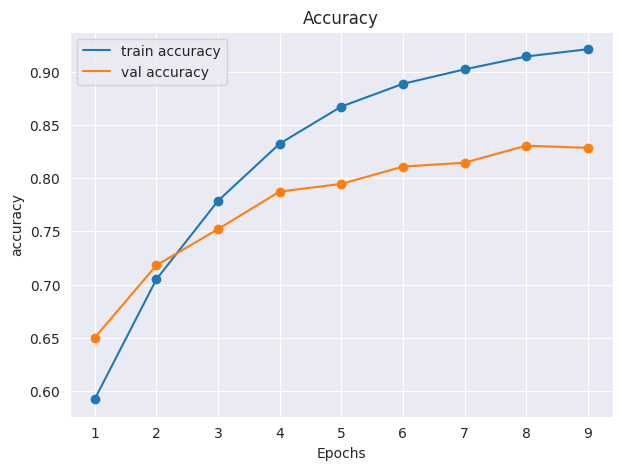

In [147]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_acc , label='train accuracy')
plt.scatter(range(1,10),epoch_tr_acc)
plt.plot(range(1,10),epoch_vl_acc , label='val accuracy')
plt.scatter(range(1,10),epoch_vl_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

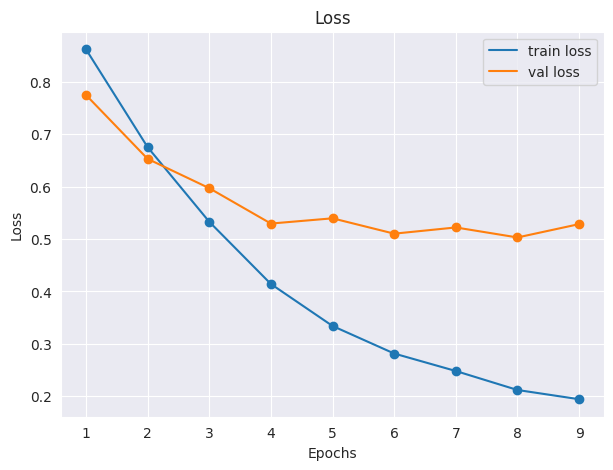

In [148]:
plt.figure(figsize=(7,5))
plt.plot(range(1,10),epoch_tr_loss , label='train loss')
plt.scatter(range(1,10),epoch_tr_loss )
plt.plot(range(1,10),epoch_vl_loss , label='val loss')
plt.scatter(range(1,10),epoch_vl_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()